In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import warnings #Warning handling
warnings.filterwarnings('ignore')

In [109]:
tracks = pd.read_csv('tracks2.csv')
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [110]:
tracks.shape

(114000, 20)

In [111]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

In [112]:
tracks.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

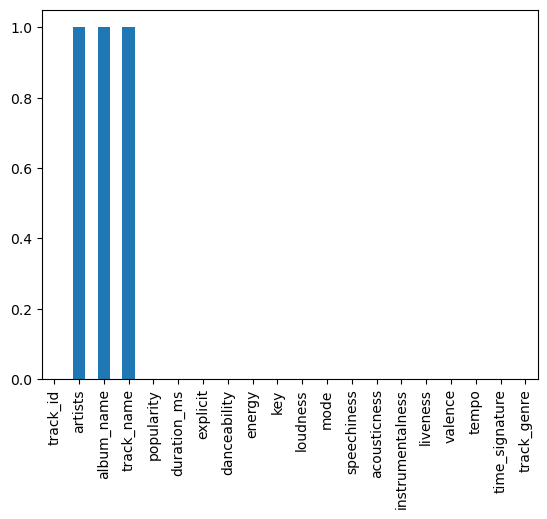

In [113]:
tracks.isnull().sum().plot.bar()
plt.show()

In [114]:
columns_to_drop = ['track_id']
tracks = tracks.drop(columns_to_drop, axis=1, errors='ignore')

# Exploratory Data Analysis(EDA)

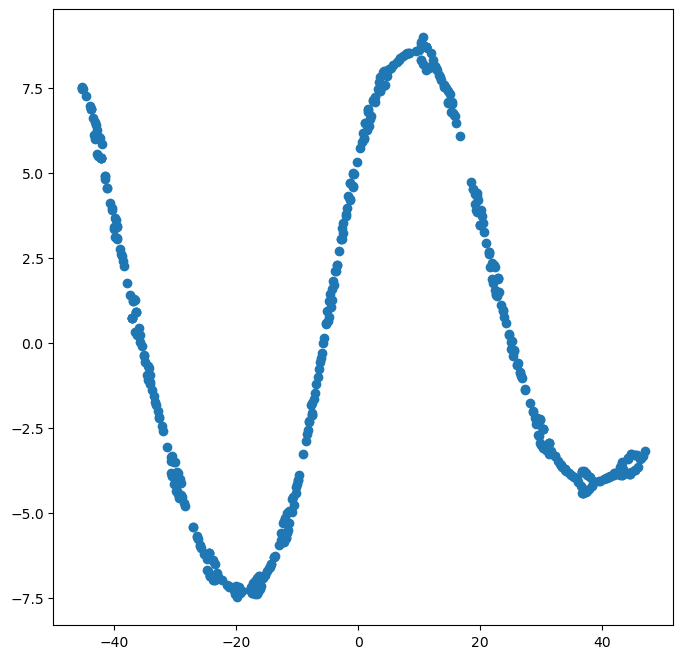

In [115]:
numeric_tracks = tracks.select_dtypes(include=[np.number])
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(numeric_tracks.head(500))
plt.figure(figsize = (8,8))
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

In [116]:
tracks['track_name'].nunique(), tracks.shape

(73602, (114000, 19))

In [117]:
tracks = tracks.sort_values(by=['popularity'], ascending = False)
tracks.drop_duplicates(subset=['track_name'], keep='first', inplace = True)

In [118]:
floats = []
for col in tracks.columns:
    if tracks[col].dtype == 'float':
     floats.append(col)
    
len(floats)

9

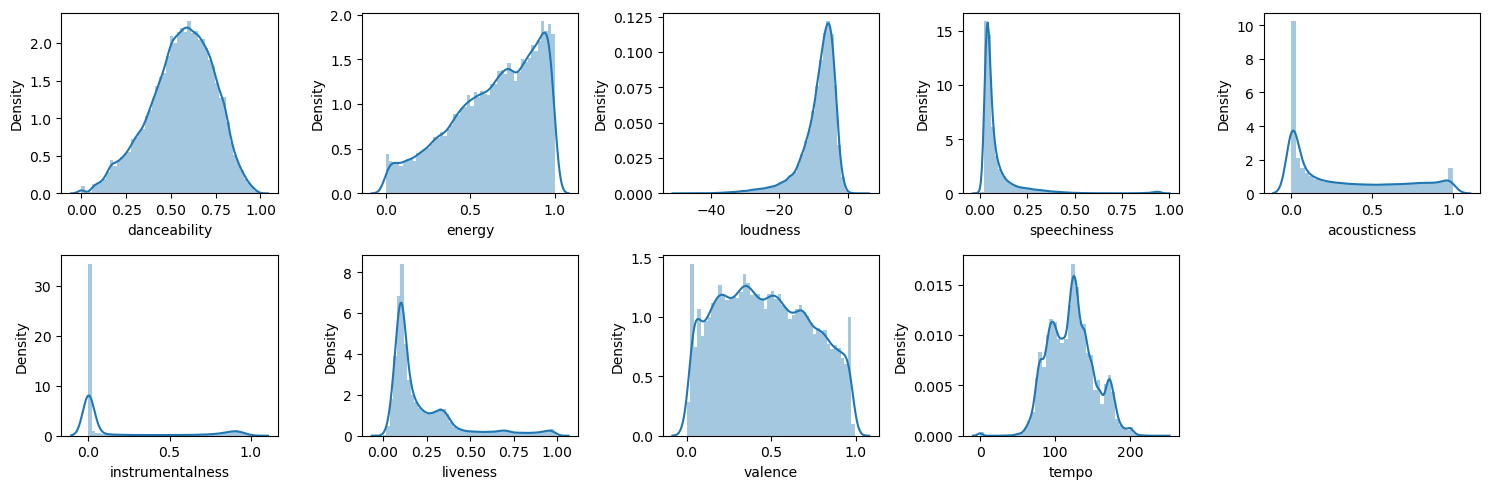

In [119]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(floats):
    plt.subplot(2, 5, i+1)
    sb.distplot(tracks[col])
plt.tight_layout()
plt.show()

#### Some of the features have normal distribution while some have skewed

In [120]:
%%capture
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['track_genre'])

In [121]:
tracks = tracks.sort_values(by=['popularity'], ascending = False).head(10000)

In [134]:
def get_similarities(song_name, data):
    text_array1 = song_vectorizer.transform(data[data['track_name']==song_name]['track_genre']).toarray()
    num_array1 = data[data['track_name']==song_name].select_dtypes(include=np.number).to_numpy()
    
    sim = []
    for idx, row in data.iterrows():
        name = row['track_name']
        
        text_array2 = song_vectorizer.transform(data[data['track_name']==name]['track_genre']).toarray()
        num_array2 = data[data['track_name']==name].select_dtypes(include=np.number).to_numpy()
    
        text_sim = cosine_similarity(text_array1, text_array2)[0][0]
        num_sim = cosine_similarity(num_array1, num_array2)[0][0]
        sim.append(text_sim + num_sim)
     
    return sim

In [135]:
def recommend_songs(song_name, data=tracks):
    if data[data['track_name'] == song_name].shape[0] == 0:
        print('This song is either not so popular or you have entered an invalid name. Some songs you may like:\n')
        
        for song in data.sample(n=5)['track_name'].values:
            print(song)
        return
    
    data['similarity_factor'] = get_similarities(song_name, data)
    
    data.sort_values(by=['similarity_factor', 'popularity'], ascending=[False, False], inplace=True)
    
    display(data[['track_name', 'artists']][2:7])

In [138]:
recommend_songs('Bad Liar')

,track_name,artists
91914,Wonderwall - Remastered,Oasis
63025,Mixed Nuts,Official HIGE DANdism
63807,まちがいさがし,Masaki Suda
63702,第六感,Reol
63005,The Rumbling,SiM
